### Reconocimiento de dígitos manuscritos con CNN

In [1]:
# Eugenio Sánchez | Noviembre 2023
# IIT | Comillas - ICAI

In [2]:
# importa paquetes
import util_mlp_cnn_ESU23
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
from torchinfo import summary
import os

c:\Users\euge.UPCONT\Miniconda3\envs\DL-TORCH\lib\site-packages\scipy\__init__.py:169: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# define hardware
device = torch.device('cpu')

#### 1. Preparamos los datos disponibles como dos datasets de imágenes
- tr_dataset: 60k imágenes para entrenar el modelo
- ts_dataset: 10k imágenes para testar el modelo

In [4]:
# Datos para entrenamiento
tr_imagefile = './data/MNIST/raw/train-images-idx3-ubyte'
tr_labelfile = './data/MNIST/raw/train-labels-idx1-ubyte'
# Datos de test
ts_imagefile = './data/MNIST/raw/t10k-images-idx3-ubyte'
ts_labelfile = './data/MNIST/raw/t10k-labels-idx1-ubyte'
# Crea los datasets de tr y ts
tr_dataset = util_mlp_cnn_ESU23.MiDataset(tr_imagefile, tr_labelfile)
ts_dataset = util_mlp_cnn_ESU23.MiDataset(ts_imagefile, ts_labelfile)

#### 2. Preparamos los cargadores para acceder realmente a los datos

In [5]:
# Define TAMAÑO DEL LOTE y crea los cargadores de datos 
batch_size = 100

train_loader = torch.utils.data.DataLoader(dataset=tr_dataset, 
                                           batch_size = batch_size,
                                           shuffle = False)  # normalmente a True
test_loader = torch.utils.data.DataLoader(dataset=ts_dataset, 
                                           batch_size = batch_size,
                                           shuffle = False)

train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([100, 1, 28, 28])
Labels batch shape: torch.Size([100])


c:\Users\euge.UPCONT\Miniconda3\envs\DL-TORCH\lib\site-packages\torchvision\transforms\functional.py:152: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_numpy.cpp:212.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


Tensor con el lote: torch.Size([100, 1, 28, 28])
Nº etiquetas del lote: torch.Size([100])


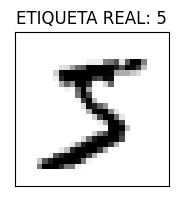

In [6]:
# prueba que está todo ok
train_imgs, train_labels = next(iter(train_loader))
print(f"Tensor con el lote: {train_imgs.size()}")
print(f"Nº etiquetas del lote: {train_labels.size()}")

img_prueba = train_imgs[0].squeeze()
label_img_prueba = train_labels[0]

fig = plt.figure(1,figsize=(2, 2))
plt.imshow(img_prueba, cmap="binary")
plt.xticks([]); plt.yticks([])
plt.title(f'ETIQUETA REAL: {label_img_prueba}')
plt.show()

#### 3. Definimos la CNN

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = torch.nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*14*14, 50),
            nn.ReLU(),
            nn.Linear(50, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        out = self.main(x)
        return out
    
model = CNN()

# Muestra la red
# print("Estructura de la red:")
# for param_tensor in model.state_dict():
#     print(f'{param_tensor} \t {model.state_dict()[param_tensor].size()}')

# resumen nº de params en cada capa
print(summary(model))
print(model)

Layer (type:depth-idx)                   Param #
CNN                                      --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       320
│    └─ReLU: 2-2                         --
│    └─MaxPool2d: 2-3                    --
│    └─Conv2d: 2-4                       18,496
│    └─ReLU: 2-5                         --
│    └─Flatten: 2-6                      --
│    └─Linear: 2-7                       627,250
│    └─ReLU: 2-8                         --
│    └─Linear: 2-9                       510
│    └─Softmax: 2-10                     --
Total params: 646,576
Trainable params: 646,576
Non-trainable params: 0
CNN(
  (main): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): Flatten(start_dim=1, end_dim=

In [8]:
# Prueba modelo bien definido
# model(train_imgs[range(2)] )

#### 4. Ajusta la CNN iterando el nº de épocas indicado

In [9]:
# función de pérdida
funcion_perdida = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizador = torch.optim.Adam(model.parameters(), lr = learning_rate)

# nº de épocas
n_epochs = 2

Ajusta el modelo con 2 épocas:


Época: 1/2  - Step: 200/600 :: loss = 1.7449090480804443
Época: 1/2  - Step: 400/600 :: loss = 1.726315975189209
Época: 1/2  - Step: 600/600 :: loss = 1.5031976699829102
Época: 2/2  - Step: 200/600 :: loss = 1.4895968437194824
Época: 2/2  - Step: 400/600 :: loss = 1.479274034500122
Época: 2/2  - Step: 600/600 :: loss = 1.4737390279769897
Modelo CNN ajustado en 2 épocas.


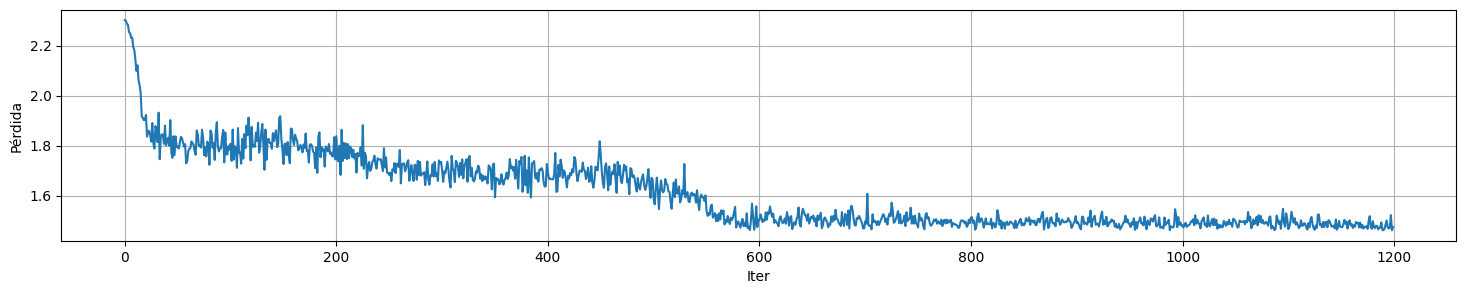

In [10]:
# Bucle de ajuste de los parámetros del modelo
n_total_steps = len(train_loader)
tr_eval_loss = np.zeros(n_epochs * n_total_steps)
k=0
print(f'Ajusta el modelo con {n_epochs} épocas:')
for epoch in range(n_epochs):
    for i, (imgs, etqs) in enumerate(train_loader):
        imgs = imgs.to(device)
        etqs = etqs.to(device)
        
        # forward
        outputs = model(imgs)
        loss = funcion_perdida(outputs, etqs)
        tr_eval_loss[k] = loss
        k+=1

        # backwards
        optimizador.zero_grad()
        loss.backward()
        optimizador.step()

        if (i+1) % 200 == 0:
            print(f'Época: {epoch+1}/{n_epochs} '
                  f' - Step: {i+1}/{n_total_steps} :: loss = {loss.item()}')


print(f'Modelo CNN ajustado en {n_epochs} épocas.')
fig = plt.figure(1,figsize=(18, 3))
plt.plot(tr_eval_loss)
plt.xlabel('Iter')
plt.ylabel('Pérdida')
plt.grid()
plt.show()

#### 5. Calcula % aciertos y matrices de confusión en TR y TS

TR ----------
   Correctas (TR):58726 Incorrectas(TR):1274
   Aciertos (TR): 97.877 %
TS ----------
   Correctas (TS):9793 Incorrectas(TS):207
   Aciertos (TS): 97.93 %


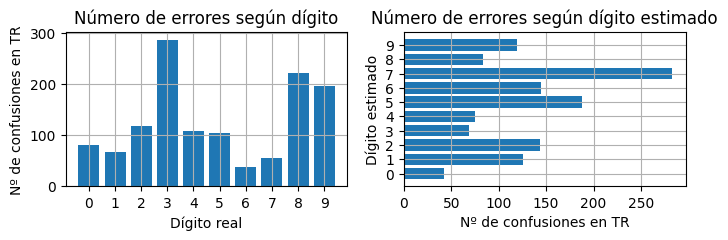

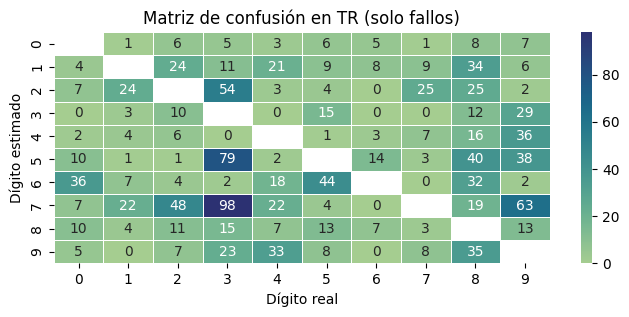

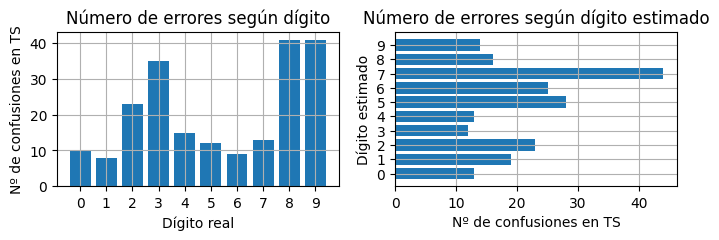

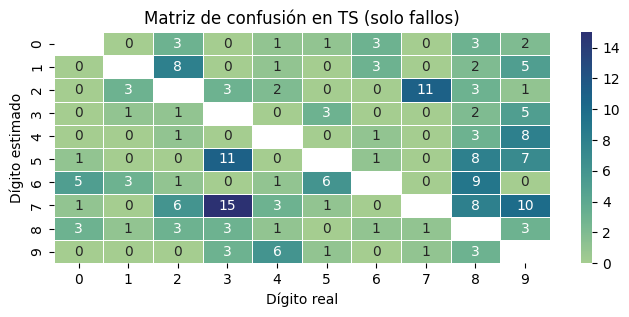

In [11]:
util_mlp_cnn_ESU23.calcula_aciertos_modelo(train_loader, model, 'TR', hacer_reshape = False)
util_mlp_cnn_ESU23.calcula_aciertos_modelo(test_loader, model, 'TS', hacer_reshape = False)

util_mlp_cnn_ESU23.calcula_matriz_confusion_modelo(train_loader, model, 'TR', 10, hacer_reshape = False)
util_mlp_cnn_ESU23.calcula_matriz_confusion_modelo(test_loader, model, 'TS', 10, hacer_reshape = False)

#### 6. Análisis imágenes mal clasificadas

In [12]:
#util_mlp_cnn_ESU23.muestra_ejemplos_fallos(train_loader, model, 'TR', digito=8, hacer_reshape = False)

Muestra 100 ejemplos de imágenes mal clasificadas en TS:


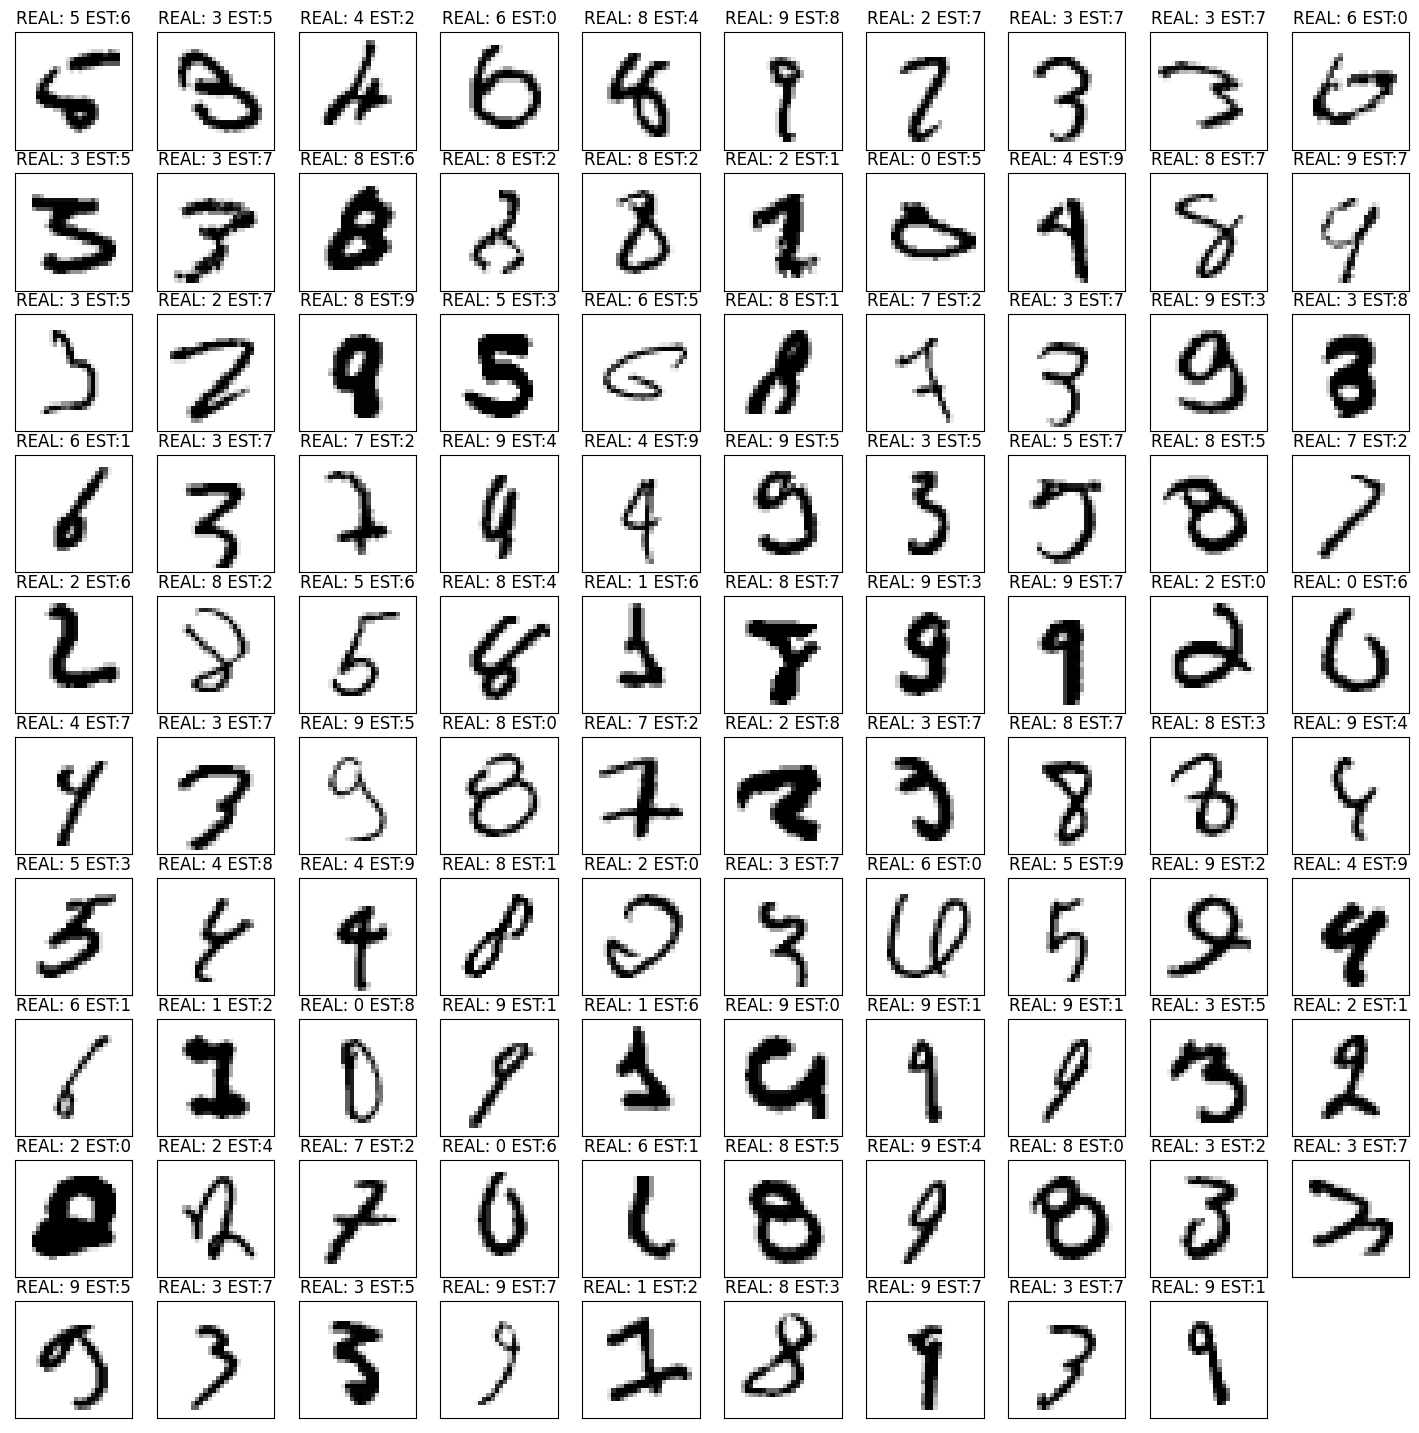

Muestra 20 ejemplos de imágenes mal clasificadas en TS del dígito 7:


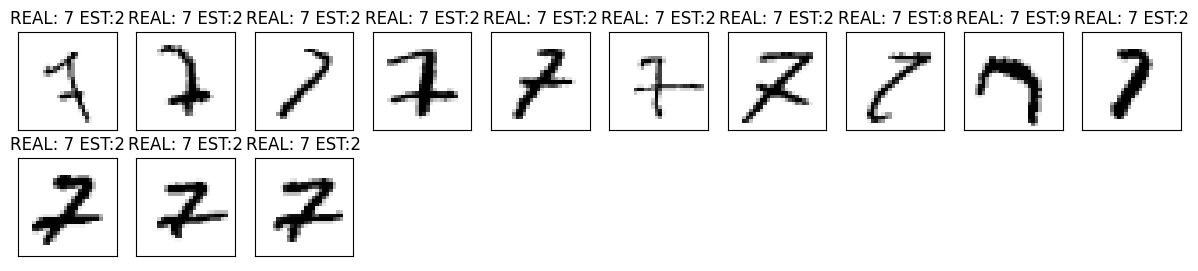

In [13]:
util_mlp_cnn_ESU23.muestra_ejemplos_fallos(test_loader, model, 'TS', digito=7, hacer_reshape = False)

#### 7. Guarda el modelo para su uso posterior

In [14]:
GUARDAR = False
if GUARDAR:
   print(f'Ruta actual: {os.getcwd()}')
   ruta_mod = os.path.join(os.getcwd(), "modelos")
   if not os.path.exists(ruta_mod):
      os.makedirs(ruta_mod)
      print(f'Se crea {ruta_mod}')

   fecha_creacion = '2023_11_16'
   nom_fi_mod = f'cnn_{n_epochs}_epocas_ajustado_MNIST_{fecha_creacion}.pth'
   ruta_fi_mod = os.path.join(ruta_mod, nom_fi_mod)
   torch.save(model.state_dict(), ruta_fi_mod)
   print(f'modelo {nom_fi_mod} guardado.')
else:
   print('No se guarda.')

No se guarda.


#### 8. Filtros estimados en la primera capa convolucional


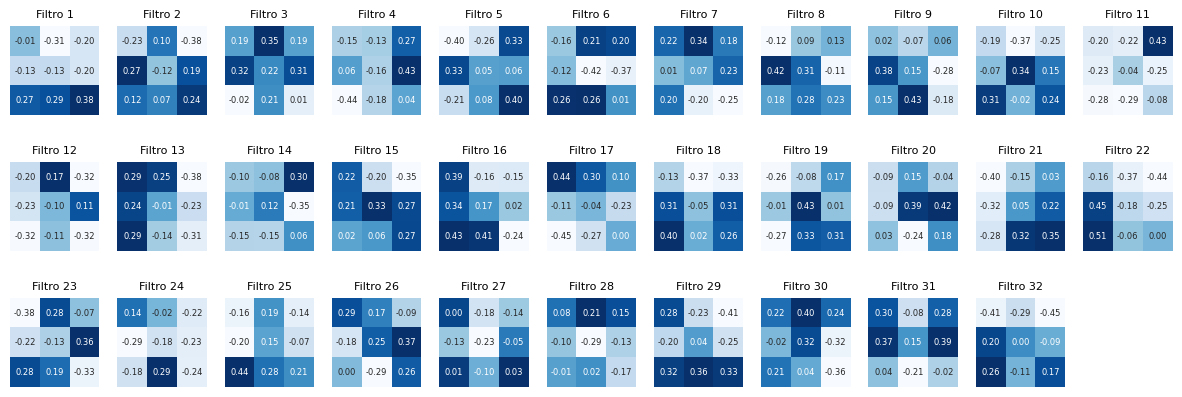

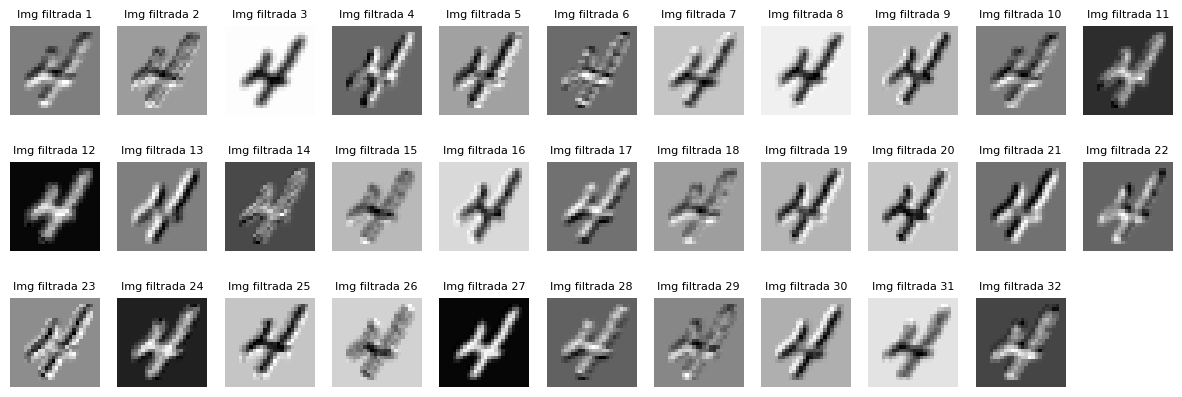

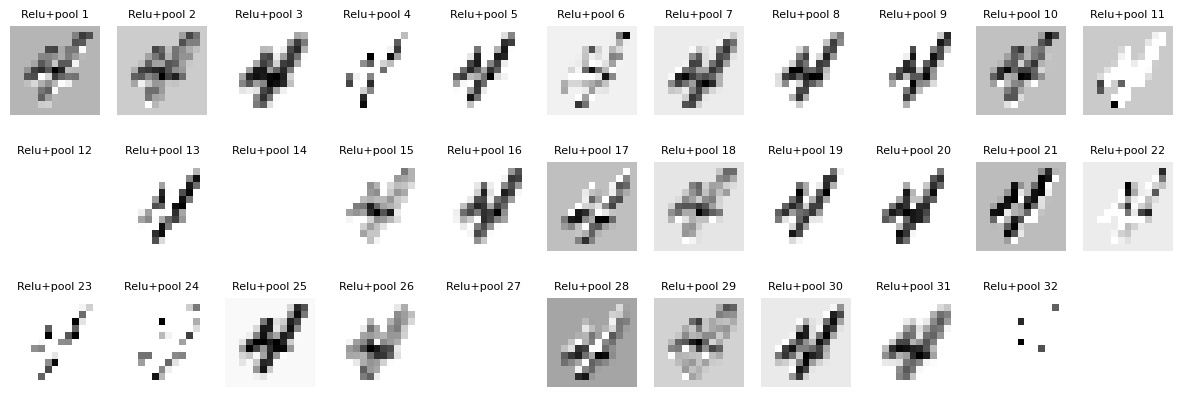

In [15]:
img_prueba = train_features[9].squeeze()

fig = plt.figure(1,figsize=(15, 5))

for f in range(32):
    plt.subplot(3,11,f+1)
    filtro = model.main[0].weight[f]
    sns.heatmap(filtro.detach().squeeze(), annot=True, square=True, annot_kws={"fontsize":6}, cmap='Blues', fmt='1.2f', cbar=False)
    plt.title(f'Filtro {f+1}', fontdict={'size': 8})
    plt.axis('off')
plt.show()

fig = plt.figure(2,figsize=(15, 5))
for f in range(32):
    with torch.no_grad():
        conv_layer_aux = nn.Conv2d(1, 1, kernel_size=(3, 3))
        conv_layer_aux.weight[0] = model.main[0].weight[f]
        filtered_image = conv_layer_aux(img_prueba[None, None, :])

    plt.subplot(3,11,f+1)
    plt.imshow(filtered_image.squeeze(), cmap=plt.cm.binary)
    plt.title(f'Img filtrada {f+1}', fontdict={'size': 8})
    plt.axis('off')
plt.show()

fig = plt.figure(3,figsize=(15, 5))
for f in range(32):
    with torch.no_grad():
        conv_layer_aux = nn.Conv2d(1, 1, kernel_size=(3, 3))
        conv_layer_aux.weight[0] = model.main[0].weight[f]
        filtered_image_relu_pool = nn.functional.max_pool2d(nn.functional.relu(conv_layer_aux(img_prueba[None, None, :])),(2,2))

    plt.subplot(3,11,f+1)
    plt.imshow(filtered_image_relu_pool.squeeze(), cmap=plt.cm.binary)
    plt.title(f'Relu+pool {f+1}', fontdict={'size': 8})
    plt.axis('off')
plt.show()